### Importing libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
#nltk.download('all')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tensorflow.python.keras.preprocessing.text import Tokenizer
import re
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional,SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

### Load imdb dataset

In [ ]:
top_words = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(path="/content/drive/MyDrive/GL_NLP_SequentialModel/imdb.npz",num_words = top_words)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

The reviews in the imdb dataset is in the form of word indexes while the target feature contains positive or negative reviews in the form of 1 and 0 respectively

#### Converting reviews in the text format

In [ ]:
word_index = tf.keras.datasets.imdb.get_word_index()
len(word_index)

88584

In [ ]:
inverted_word_index = {idx : word for word,idx in word_index.items()}
len(inverted_word_index) 

88584

#### Converting all training and test samples to text so that we can apply our own text preprocessing steps

In [ ]:
x_train_text = []
x_test_text = []
#---for train data---#
for sample in range(len(x_train)):
  x_train_text.append(" ".join(inverted_word_index[index] for index in x_train[sample]))

#---for test data----#
for sample in range(len(x_test)):
  x_test_text.append(" ".join(inverted_word_index[index] for index in x_test[sample]))

In [ ]:
x_train_text = np.array(x_train_text)
x_test_text = np.array(x_test_text)

### Shape and count of unique values

In [ ]:
print(x_train_text.shape)
print(x_test_text.shape)

(25000,)
(25000,)


#### Count of zeros and ones in train and test data

In [ ]:
train_count = np.bincount(y_train)
i = np.nonzero(train_count)[0]
np.vstack((i, train_count[i])).T

array([[    0, 12500],
       [    1, 12500]])

In [ ]:
test_count = np.bincount(y_test)
ii = np.nonzero(test_count)[0]
np.vstack((ii, test_count[ii])).T

array([[    0, 12500],
       [    1, 12500]])

### Text preprocessing

In [ ]:
lemma = WordNetLemmatizer()

#### Custom transformer for textprocessing



In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords

class TextPreprocessing(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
    
  def fit(self, train):
    self.train = train
  
  @staticmethod
  def remove_html(sentences):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    for i in range(len(sentences)):
      sentences[i] = re.sub(cleanr, '', sentences[i])
    return sentences
  
  @staticmethod
  def remove_extra_whitespace_tabs(sentences):
    #pattern = r'^\s+$|\s+$'
    pattern = r'^\s*|\s\s*'
    for i in range(len(sentences)):
      sentences[i] = re.sub(pattern, ' ', sentences[i]).strip()

  @staticmethod
  def tokenize(sample):
    """Sentence Tokenizer"""
    sentences = sent_tokenize(sample)
    return sentences

  @staticmethod
  def remove_special_chars(sentences):
    """Removing special characters"""
    for i in range(len(sentences)):
      sentences[i] = re.sub("[^A-Za-z0-9]"," ",sentences[i])
    return sentences

  @staticmethod
  def remove_stopwords(sentences):
    """Removing stopwords"""
    stop_words = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])
    for i in range(len(sentences)):
      sentences[i] = " ".join(word for word in sentences[i].split() if word.lower not in stop_words)
    return sentences
  
  @staticmethod
  def lemmatize(sentences):
    """lemmatization"""
    for i in range(len(sentences)):
      sentences[i] = " ".join(lemma.lemmatize(word) for word in sentences[i].split())
    return sentences
  
  @staticmethod
  def remove_emojis(sentences):
    """removing emojis"""
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    for i in range(len(sentences)):
      sentences[i] = emoji.sub(r'',sentences[i])
    return sentences
  
  @staticmethod
  def remove_urls(sentences):
    """removing urls"""
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    for i in range(len(sentences)):
      sentences[i] = pattern.sub('',sentences[i])
    return sentences
  
  @staticmethod
  def to_lower(sentences):
    for i in range(len(sentences)):
      sentences[i] = sentences[i].lower()
    return sentences

  @staticmethod
  def fix_shortforms(sentences):
    """fix short forms"""

    for i in range(len(sentences)):
      sentences[i] = re.sub(r"i'm", "i am", sentences[i])
      sentences[i] = re.sub(r"he's", "he is", sentences[i])
      sentences[i] = re.sub(r"she's", "she is", sentences[i])
      sentences[i] = re.sub(r"that's", "that is", sentences[i])        
      sentences[i] = re.sub(r"what's", "what is", sentences[i])
      sentences[i] = re.sub(r"where's", "where is", sentences[i]) 
      sentences[i] = re.sub(r"\'ll", " will", sentences[i])  
      sentences[i] = re.sub(r"\'ve", " have", sentences[i])  
      sentences[i] = re.sub(r"\'re", " are", sentences[i])
      sentences[i] = re.sub(r"\'d", " would", sentences[i])
      sentences[i] = re.sub(r"\'ve", " have", sentences[i])
      sentences[i] = re.sub(r"won't", "will not", sentences[i])
      sentences[i] = re.sub(r"don't", "do not", sentences[i])
      sentences[i] = re.sub(r"did't", "did not", sentences[i])
      sentences[i] = re.sub(r"can't", "can not", sentences[i])
      sentences[i] = re.sub(r"it's", "it is", sentences[i])
      sentences[i] = re.sub(r"couldn't", "could not", sentences[i])
      sentences[i] = re.sub(r"have't", "have not", sentences[i])
      sentences[i] = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", sentences[i])
    return sentences
      

  def transform(self):
    data = []
    for sample in self.train:
      sent = self.tokenize(sample)
      sent = self.remove_stopwords(sent)
      sent = self.fix_shortforms(sent)
      sent = self.remove_special_chars(sent)
      sent = self.remove_emojis(sent)
      sent = self.remove_urls(sent)
      sent = self.lemmatize(sent)
      sent = self.to_lower(sent)
      sent = " ".join(sent)
      data.append(sent)
    return np.array(data)




#### Creating wordcloud to see most frequent words in positive('1') and negative('0') reviews

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
pos_data = np.array([review for idx,review in enumerate(x_train_text) if idx in np.where(y_train==1)[0] ])
neg_data = np.array([review for idx, review in enumerate(x_train_text) if idx in np.where(y_train==0)[0] ])


##### Transforming the data

In [ ]:
#---for positive reviews---#
pro_pos = TextPreprocessing()
pro_pos.fit(pos_data)
pos_data_clean = pro_pos.transform()
#--for negative reviews---#
neg_pos = TextPreprocessing()
neg_pos.fit(neg_data)
neg_data_clean = neg_pos.transform()

##### splitting the words and storing the count in word dict

In [ ]:
pos_data_words = [review.split() for review in pos_data_clean]
pos_data_words = [word for review in pos_data_words for word in review]
neg_data_words = [review.split() for review in neg_data_clean]
neg_data_words = [word for review in neg_data_words for word in review]

##### Count of the words in the corpus stored

In [ ]:
from collections import Counter
pos_wordcloud_dict = Counter(pos_data_words)
neg_wordcloud_dict = Counter(neg_data_words)

##### Positive review wordcloud

(-0.5, 999.5, 499.5, -0.5)

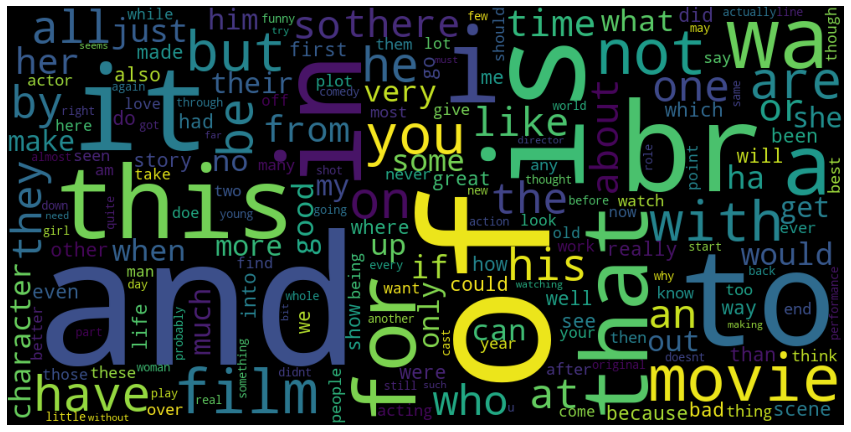

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(pos_wordcloud_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

##### Negative review wordcloud

(-0.5, 999.5, 499.5, -0.5)

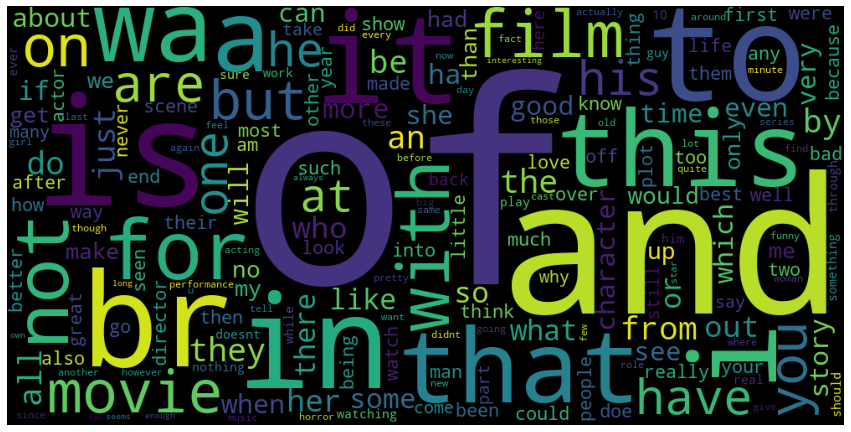

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(neg_wordcloud_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

### Preparation of train and test data from word index

#### Converting the training data into vectors of word indices

In [ ]:
token_obj = Tokenizer(num_words=10000)
#Data Preprocessing
preprocess = TextPreprocessing()
preprocess.fit(x_train_text)
x_train_transformed = preprocess.transform()
#converting to sequences of word indices
token_obj.fit_on_texts(x_train_transformed)
x_train_sequences = token_obj.texts_to_sequences(x_train_transformed)


In [ ]:
preprocess.fit(x_test_text)
x_test_transformed = preprocess.transform()
x_test_sequences = token_obj.texts_to_sequences(x_test_transformed)

#### Word indices

In [ ]:
word_index = token_obj.word_index
word_index

{'and': 1,
 'of': 2,
 'is': 3,
 'to': 4,
 'br': 5,
 'in': 6,
 'it': 7,
 'i': 8,
 'this': 9,
 'that': 10,
 'wa': 11,
 'a': 12,
 'for': 13,
 'not': 14,
 'movie': 15,
 'film': 16,
 'with': 17,
 'but': 18,
 'on': 19,
 'you': 20,
 'are': 21,
 'have': 22,
 'he': 23,
 'his': 24,
 'be': 25,
 'one': 26,
 'all': 27,
 'at': 28,
 'by': 29,
 'the': 30,
 'they': 31,
 'an': 32,
 'who': 33,
 'so': 34,
 'from': 35,
 'like': 36,
 'her': 37,
 'or': 38,
 'just': 39,
 'there': 40,
 'about': 41,
 'do': 42,
 'out': 43,
 'what': 44,
 'ha': 45,
 'time': 46,
 'if': 47,
 'some': 48,
 'good': 49,
 'more': 50,
 'when': 51,
 'would': 52,
 'very': 53,
 'can': 54,
 'character': 55,
 'she': 56,
 'up': 57,
 'no': 58,
 'story': 59,
 'will': 60,
 'get': 61,
 'even': 62,
 'my': 63,
 'which': 64,
 'only': 65,
 'see': 66,
 'make': 67,
 'really': 68,
 'their': 69,
 'had': 70,
 'we': 71,
 'were': 72,
 'me': 73,
 'well': 74,
 'scene': 75,
 'than': 76,
 'much': 77,
 'been': 78,
 'bad': 79,
 'could': 80,
 'people': 81,
 'also': 

#### Function to convert sequences to text for analysis

In [ ]:
inverse_map = dict(zip(word_index.values(), word_index.keys()))

In [ ]:
def tokens_to_string(data):
  words = [inverse_map[token] for token in data if token != 0]
  text = " ".join(words)
  return text

In [ ]:
print(x_train_sequences[0])
print(tokens_to_string(x_train_sequences[0]))

[30, 12, 20, 17, 43, 523, 944, 252, 112, 69, 463, 4039, 70, 3625, 2, 150, 35, 263, 4, 22, 104, 43, 812, 117, 50, 594, 1, 7, 34, 444, 93, 4, 107, 2, 177, 117, 170, 1, 292, 244, 38, 2, 177, 4100, 1088, 15, 543, 37, 11, 455, 2, 198, 50, 17, 3, 153, 1942, 16, 12, 20, 2, 1664, 4162, 475, 2, 20, 76, 90, 10, 17, 43, 523, 37, 61, 13, 11, 1157, 2, 20, 15, 510, 15, 10, 17, 627, 18, 1, 4, 59, 388, 10, 6, 318, 6, 55, 4, 2, 843, 2908, 17, 444, 70, 1727, 31, 2, 130, 10, 17, 37, 620, 4, 22, 126, 51, 35, 137, 44, 22, 1116, 31, 3, 20, 10, 216, 26, 60, 53, 4, 12, 414, 17, 85, 1, 6, 2, 111, 121, 5280, 13, 263, 2, 1, 5, 93, 4, 710, 35, 76, 43, 523, 484, 23, 333, 319, 48, 5, 2, 1, 1003, 11, 105, 91, 2, 275, 13, 301, 100, 32, 1983, 56, 23, 140, 3, 192, 6541, 18, 2, 214, 20, 14, 136, 484, 23, 444, 4, 148, 28, 4943, 18, 51, 35, 26, 207, 94, 22, 105, 2, 214, 69, 17, 37, 1317, 91, 10, 17, 289, 4, 17, 4040, 118, 103, 32, 13, 17, 4800, 16, 146, 32]
the a you with out themselves powerful let love their becomes rea

#### Padding of train and test data

In [ ]:
word_count = [len(review) for review in x_train_transformed]
print(word_count)
max_len = int(np.mean(word_count) + 2*np.std(word_count))
print("Max Length = ", max_len)

[1097, 944, 679, 2696, 735, 219, 654, 2916, 1112, 638, 2207, 481, 548, 1235, 547, 681, 790, 3814, 1028, 903, 587, 756, 1245, 4474, 442, 707, 1092, 939, 857, 1111, 861, 3246, 1164, 782, 3225, 1190, 279, 1720, 693, 1151, 3673, 730, 4432, 615, 604, 2982, 307, 1049, 581, 967, 604, 821, 2455, 681, 1529, 3927, 1711, 720, 281, 1013, 495, 795, 892, 2192, 748, 3603, 1940, 1691, 1182, 1393, 3876, 1127, 1581, 534, 1982, 727, 3566, 1573, 871, 559, 412, 771, 759, 418, 2589, 1534, 1015, 893, 290, 762, 1056, 3506, 1988, 2662, 2182, 1006, 1200, 819, 508, 879, 766, 723, 4016, 1280, 1612, 333, 591, 5023, 4043, 1159, 970, 1342, 1046, 493, 5253, 4153, 943, 1036, 241, 580, 720, 721, 302, 275, 2271, 2170, 1128, 696, 2593, 1543, 1070, 2769, 669, 714, 272, 497, 930, 999, 946, 809, 385, 968, 733, 1116, 633, 298, 1879, 420, 293, 917, 779, 272, 784, 809, 1099, 940, 755, 670, 970, 93, 519, 2418, 2726, 700, 1567, 725, 2160, 1084, 2289, 724, 737, 1766, 1290, 1540, 655, 990, 1385, 4169, 744, 1182, 704, 1043, 1014, 5

In [ ]:
x_train_pad = pad_sequences(x_train_sequences,maxlen=max_len,padding='pre',truncating='pre')
x_test_pad = pad_sequences(x_test_sequences,maxlen=max_len,padding='pre',truncating='pre')

print(x_train_pad.shape)
print(x_test_pad.shape)


(25000, 3007)
(25000, 3007)


### LSTM model with Normal Embedding

In [ ]:
embed_dim = 128
lstm_out = 128

model = Sequential()
model.add(Embedding(10000, embed_dim,input_length = x_train_pad.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 3007, 128)         1280000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 3007, 128)         0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                min_delta=0, 
                                patience=0, 
                                verbose=0, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=False)

In [ ]:
%%time
history1 = model.fit(x_train_pad, y_train, epochs = 16, batch_size=64,validation_data=(x_test_pad,y_test),callbacks = [callbacks],verbose = True)


Epoch 1/16
391/391 [==============================] - 103s 260ms/step - loss: 0.5757 - accuracy: 0.6808 - val_loss: 0.3393 - val_accuracy: 0.8598
Epoch 2/16
391/391 [==============================] - 101s 258ms/step - loss: 0.2807 - accuracy: 0.8873 - val_loss: 0.3277 - val_accuracy: 0.8612
Epoch 3/16
391/391 [==============================] - 101s 258ms/step - loss: 0.2137 - accuracy: 0.9186 - val_loss: 0.3693 - val_accuracy: 0.8472
CPU times: user 3min 55s, sys: 56.3 s, total: 4min 51s
Wall time: 5min 4s


### Visualizing the train parameters vs validation parameters


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


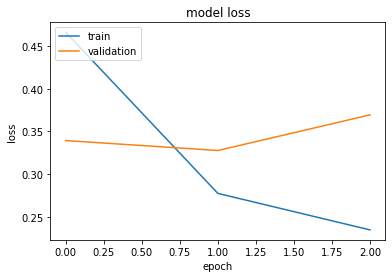

In [ ]:
print(history1.history.keys())
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


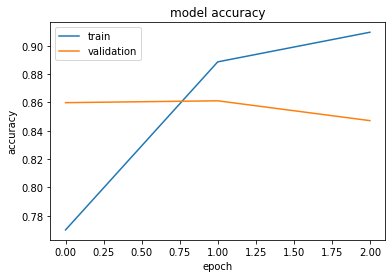

In [ ]:
print(history1.history.keys())
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Loading glove model

In [ ]:
embedding_index = {}
embedding_dim = 50
glove_dir = r"/content/drive/MyDrive/GL_NLP_SequentialModel/word2vec.glove.6B.50d.txt"
with open(glove_dir,encoding = "utf-8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embedding_index[word] = coefs
print("length of Word vectors = ", len(embedding_index))

length of Word vectors =  400001


#### Building the embedding layer




In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
print("Shape of the embedding matrix = ",embedding_matrix.shape)
count = 0
for word, index in word_index.items():
  #---always use '.get' method with dictionaries like embedding_index since 
  #---it wont produce 'keyerror' exception when there is no key in the dictionary---#
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    count += 1
    embedding_matrix[index] =  embedding_vector
print(count)

Shape of the embedding matrix =  (8673, 50)
8647


In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

### Building the LSTM model with glove embeddings

In [ ]:
from keras.optimizers import Adam
optimizer = Adam(lr=1e-2)
sgd = tf.keras.optimizers.SGD(
    learning_rate=0.1, nesterov=True, name="SGD",
)

In [ ]:
glove = Sequential()
glove.add(embedding_layer)
glove.add(SpatialDropout1D(0.4))
glove.add(LSTM(lstm_out))
glove.add(Dense(1,activation='sigmoid'))
glove.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(glove.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3007, 50)          433650    
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 3007, 50)          0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 128)               91648     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 525,427
Trainable params: 91,777
Non-trainable params: 433,650
_________________________________________________________________
None


In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                min_delta=0, 
                                patience=6, 
                                verbose=0, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=False)

In [ ]:
%%time
history = glove.fit(x_train_pad, y_train, epochs = 30, callbacks=[callbacks], batch_size=64,validation_data=(x_test_pad,y_test),verbose = True)


Epoch 1/30
391/391 [==============================] - 82s 208ms/step - loss: 0.6919 - accuracy: 0.5297 - val_loss: 0.6905 - val_accuracy: 0.5202
Epoch 2/30
391/391 [==============================] - 81s 206ms/step - loss: 0.6827 - accuracy: 0.5462 - val_loss: 0.6683 - val_accuracy: 0.5718
Epoch 3/30
391/391 [==============================] - 81s 207ms/step - loss: 0.6693 - accuracy: 0.5628 - val_loss: 0.6481 - val_accuracy: 0.5998
Epoch 4/30
391/391 [==============================] - 81s 208ms/step - loss: 0.6463 - accuracy: 0.5970 - val_loss: 0.6280 - val_accuracy: 0.6340
Epoch 5/30
391/391 [==============================] - 82s 209ms/step - loss: 0.6286 - accuracy: 0.6246 - val_loss: 0.5996 - val_accuracy: 0.6597
Epoch 6/30
391/391 [==============================] - 81s 208ms/step - loss: 0.6151 - accuracy: 0.6435 - val_loss: 0.5805 - val_accuracy: 0.6864
Epoch 7/30
391/391 [==============================] - 82s 209ms/step - loss: 0.5977 - accuracy: 0.6621 - val_loss: 0.5650 - val_ac

In [ ]:
y_pred = glove.predict_classes(x_test_pad)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.88      0.79     12500
           1       0.85      0.66      0.74     12500

    accuracy                           0.77     25000
   macro avg       0.79      0.77      0.77     25000
weighted avg       0.79      0.77      0.77     25000



### Visualizing the train parameters vs validation parameters




dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


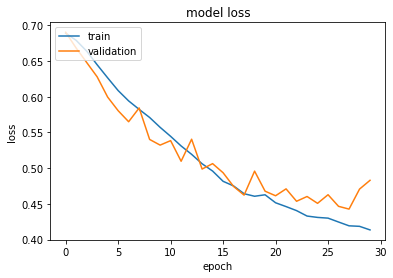

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


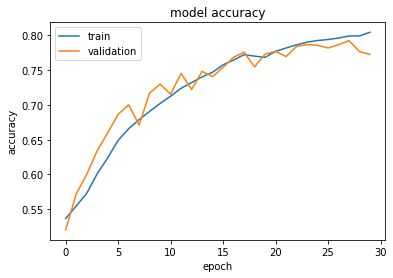

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Checking our model performance on random imdb movie review

#### This is the positive review of the anime movie Mugen train which has grossed over 470 million dollars

In [ ]:
review = """I'm out of words to describe it after watching. The overall story, animation and fight scenes are amazing. The red flames if Rengoku San are so amazing, I've never seen this type of animation in other anime so far. It's wonderful.

I would like to thank the original manga creator Koyoharu Gotouge for giving us this master piece.

Demon slayer was my 2nd anime and I loved it so much as a normie. It made me teary at some at some point and the movie gives you same vibes. I already knew the ending still it made the heart melt. :("""

In [ ]:
preprocess = TextPreprocessing()
preprocess.fit([review])
review_transformed = preprocess.transform()

In [ ]:
review_transformed

array(['im out of word to describe it after watching the overall story animation and fight scene are amazing the red flame if rengoku san are so amazing i have never seen this type of animation in other anime so far its wonderful i would like to thank the original manga creator koyoharu gotouge for giving u this master piece demon slayer wa my 2nd anime and i loved it so much a a normie it made me teary at some at some point and the movie give you same vibe i already knew the ending still it made the heart melt '],
      dtype='<U509')

In [ ]:
sequences = token_obj.texts_to_sequences(review_transformed)

In [ ]:
sequences

[[4189,
  43,
  2,
  361,
  4,
  1583,
  7,
  104,
  152,
  30,
  446,
  59,
  703,
  1,
  451,
  75,
  21,
  486,
  30,
  748,
  4075,
  47,
  2497,
  21,
  34,
  486,
  8,
  22,
  117,
  111,
  9,
  465,
  2,
  703,
  6,
  85,
  2066,
  34,
  226,
  388,
  8,
  52,
  36,
  4,
  1267,
  30,
  203,
  7436,
  2332,
  13,
  727,
  160,
  9,
  1066,
  337,
  1469,
  11,
  63,
  3663,
  2066,
  1,
  8,
  448,
  7,
  34,
  77,
  12,
  12,
  7,
  92,
  73,
  28,
  48,
  28,
  48,
  176,
  1,
  30,
  15,
  147,
  20,
  172,
  7158,
  8,
  462,
  679,
  30,
  272,
  132,
  7,
  92,
  30,
  444,
  7955]]

In [ ]:
_review_pad = pad_sequences(sequences,maxlen=max_len,padding='pre',truncating='pre')

In [ ]:
glove.predict(_review_pad)[0]

array([0.72179973], dtype=float32)

##### From above we can see that prediction is very close to 1 i.e positive 

#### A negative review example(Movie name:Radhe)

In [ ]:
review1 = """It's so cringe so see 55 year old grandpa romancing with 28 year old girl. Salman you had your fame and glory now it's time to retire from acting. Only salman's illiterate audience will like this movie. Salman is the worst thing happened to bollywood and humanity. Save yourself from this pandemic.
"""

In [ ]:
preprocess = TextPreprocessing()
preprocess.fit([review1])
review1_transformed = preprocess.transform()

In [ ]:
review1_transformed

array(['its so cringe so see 55 year old grandpa romancing with 28 year old girl salman you had your fame and glory now it is time to retire from acting only salmans illiterate audience will like this movie salman is the worst thing happened to bollywood and humanity save yourself from this pandemic'],
      dtype='<U292')

In [ ]:
sequences1 = token_obj.texts_to_sequences(review1_transformed)

In [ ]:
sequences1

[[34,
  3692,
  34,
  66,
  107,
  156,
  7453,
  17,
  5271,
  107,
  156,
  175,
  5711,
  20,
  70,
  129,
  2139,
  1,
  3076,
  153,
  7,
  3,
  46,
  4,
  35,
  118,
  65,
  8192,
  251,
  60,
  36,
  9,
  15,
  5711,
  3,
  30,
  247,
  95,
  570,
  4,
  2714,
  1,
  1876,
  535,
  624,
  35,
  9]]

In [ ]:
_review1_pad = pad_sequences(sequences1,maxlen=max_len,padding='pre',truncating='pre')

In [ ]:
model.predict(_review1_pad)

array([[0.825363]], dtype=float32)

In [ ]:
glove.predict(_review1_pad)

array([[0.52302694]], dtype=float32)

<b>Conclusion:</b>


1.   We trained the lstm model with normal word index embedding and glove embedding
2.   lstm model trained with normal embedding converged faster but on our negative review sample it performed not so well. 
3. Even though the convergence of lstm model trained with glove embedding is slow. It performs well on negative reviews since it takes the global context and not the local contect in a corpus.
4. With more computational resources and time the lstm model trained with glove embedding would perform much better when compared to normal embeddings since the convegence is consistent even though it is slow and also since it takes global context into consideration.

